In [1]:
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt

### my library

import plots
import utils
import images
import distances
import transforms
import alignments

In [2]:
colors = {'sw_nrf': 'dodgerblue',
          'sw_sgn': 'skyblue',
          'sw_max': 'pink',
          'sc_nrf': 'green',
          'bf': 'salmon', 
          'w2': 'blue'}


def gaussian_2d(N, A=1, sig_x=1, sig_y=1):
    """returns simple 2D Gaussian over range -3 to 3 of size NxN"""
    
    # Make this a better function
    
    xs = np.linspace(-3, 3, N)
    ys = np.linspace(-3, 3, N)

    x, y = np.meshgrid(xs, ys)

    g = A*np.exp(-((x**2 / 2*sig_x**2) + (y**2 / 2*sig_y**2)))
    
    return g

In [3]:
### Generate Gaussian blob image with and without deformation
### - use odd size image for centering

amp = 1000  # a.u.
ny = 101
nx = 101

g = gaussian_2d(ny, A=amp, sig_x=3, sig_y=3)  # using large amplitude because of scaling

x1 = np.zeros((ny, nx))
x2 = np.zeros((ny, nx))

x1[50, 60] = 1

x2 = utils.translate(utils.rotate(x1, 180), 0, -20)

x1 = transforms.ift2(transforms.ft2(x1) * g).real
x2 = transforms.ift2(transforms.ft2(x2) * g).real

x1 = np.where(x1 < 0, 0, x1)
x2 = np.where(x2 < 0, 0, x2)

# plots.two_imshow(x1, x2)

In [4]:
x = np.array([x1, x2])
x = images.Image(x, normalize=True, mask=True).preprocess_images()

refs = np.array([x[0], x[0]])
imgs = np.array([x[1], x[1]])

In [5]:
### compute distances

N, ny, nx = imgs.shape

angles = np.linspace(0, 360, ny, endpoint=False)
n_points = ny
n_theta = len(angles)


### *** SLICED WASSERSTEIN DISTANCES *** ###


### sliced Wasserstein (no ramp filter)
t = time.time()
U = transforms.Transform(refs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
V = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
dists_sw_nrf = distances.reference_rotational_distances(U[0], V)[0]
print('SW nrf runtime: ', time.time() - t)


### sliced Wasserstein distance (signed)
t = time.time()
Up, Un = transforms.Transform(refs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
Vp, Vn = transforms.Transform(imgs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
dists_sw_sgn = distances.reference_signed_rotational_distances(Up[0], Vp, Un[0], Vn)[0]
print('SW avg runtime: ', time.time() - t)


### max sliced Wasserstein distance
t = time.time()
U = transforms.Transform(refs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
V = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
dists_sw_max = distances.reference_rotational_max_sliced_wasserstein(U[0], V, n_theta, N)[0]
print('SW max runtime: ', time.time() - t)


### *** SLICED CRAMER DISTANCES *** ###
print('\n')


### sliced Cramer distance (no ramp filter)
t = time.time()
U = transforms.Transform(refs, apply_ramp=False, angles=angles, n_points=n_points).cdf_transform(rescale=True)
V = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).cdf_transform(rescale=True)
dists_sc_nrf = distances.reference_rotational_distances(U[0], V)[0]
print('SC nrf runtime: ', time.time() - t)



### *** OTHER DISTANCES *** ###
print('\n')


## Brute force rotations
t = time.time()
dists_bf = distances.real_space_rotational_distance(refs[0], imgs[0], angles)
print('    BF runtime: ', time.time() - t)


### Wavelet EMD 
t = time.time()
dists_wemd = distances.wemd_rotational_distance(refs[0], imgs[0], angles, wavelet='sym3', level=3)
print('  WEMD runtime: ', time.time() - t)


# ### Wasserstein 1
# t = time.time()
# M = distances.compute_transport_matrix(imgs[0], metric='euclidean')
# dists_dict_w1 = {idx: distances.rotational_wasserstein_distance(ref_img, imgs[idx], angles, M) for idx in range(N)}
# angles_est_w1 = np.array([angles[np.argmin(dists)] for idx, dists in dists_dict_w1.items()])
# print('    W1 runtime: ', time.time() - t)

angles_w2 = np.array([0, 45, 90, 135, 180, 225, 270, 315, 360])
## Wasserstein 2
t = time.time()
M = distances.compute_transport_matrix(imgs[0], metric='sqeuclidean')
dists_w2 = distances.rotational_wasserstein_distance(refs[0], imgs[0], angles_w2, M)
print('    W2 runtime: ', time.time() - t)

SW nrf runtime:  0.019481420516967773
SW avg runtime:  0.020349979400634766
SW max runtime:  0.022497177124023438


SC nrf runtime:  0.012233734130859375


    BF runtime:  0.10234284400939941
  WEMD runtime:  0.14187335968017578


/home/ev9102/.local/lib/python3.9/site-packages/ot/lp/__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


    W2 runtime:  34.76895880699158


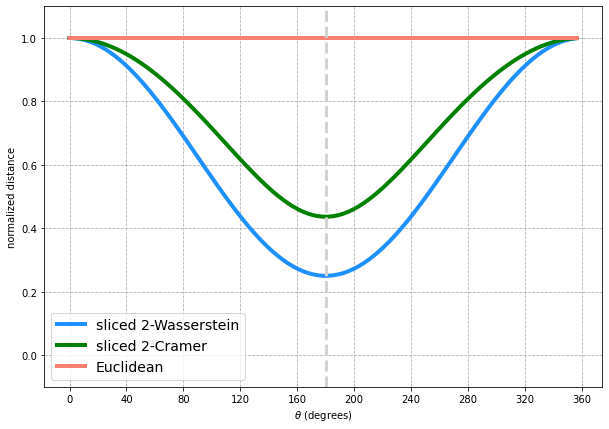

In [6]:
plt.figure(figsize=(10,7))

plt.plot(angles, dists_sw_nrf / np.amax(dists_sw_nrf), color=colors['sw_nrf'], linewidth=4, label='sliced 2-Wasserstein')
# plt.plot(angles, dists_sw_sgn / np.amax(dists_sw_sgn), color=colors['sw_sgn'], linewidth=4, label='sliced 2-Wasserstein (signed)')
# plt.plot(angles, dists_sw_max / np.amax(dists_sw_max), color=colors['sw_max'], linewidth=4, label='max sliced 2-Wasserstein')

plt.plot(angles, dists_sc_nrf / np.amax(dists_sc_nrf), color=colors['sc_nrf'], linewidth=4, label='sliced 2-Cramer')

# plt.plot(angles, dists_w2 / np.amax(dists_w2), color=colors['w2'], linewidth=4, label='2-Wasserstein')
# plt.plot(angles, dists_wemd, color=colors['wemd'], linewidth=4, label='WEMD')
plt.plot(angles, dists_bf / np.amax(dists_bf), color=colors['bf'], linewidth=4, label='Euclidean')

plt.axvline(180, color='lightgray', linestyle='--', linewidth=3)


plt.ylim(-0.1, 1.1)
plt.xticks(np.arange(0, 361, 40))
plt.grid(which='major', linestyle='--')
plt.ylabel('normalized distance')
plt.xlabel(r"$\theta$ " '(degrees)')
# plt.xticks(np.linspace(0, 2*np.pi, 9, endpoint=True),
#            ['0', '$\pi$/4', '$\pi$/2', '$3\pi$/4', '$\pi$', '5$\pi$/4', '3$\pi$/2', '7$\pi$/4', '2$\pi$'])
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=14)
plt.legend()
plt.show()

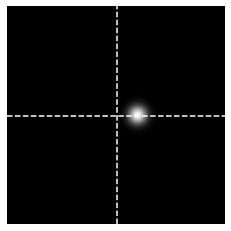

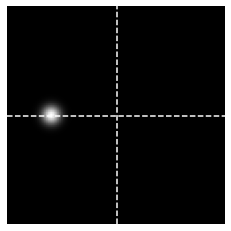

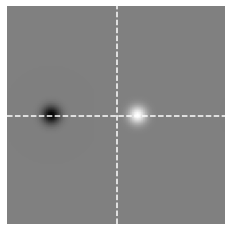

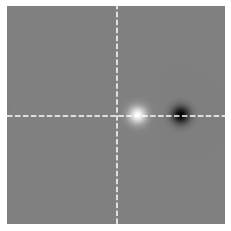

In [7]:
plt.imshow(x[0], cmap='gray')
plt.axvline(ny/2, color='white', linestyle='--')
plt.axhline(nx/2, color='white', linestyle='--')
# plt.colorbar()
plt.axis('off')
plt.show()

plt.imshow(x[1], cmap='gray')
plt.axvline(ny/2, color='white', linestyle='--')
plt.axhline(nx/2, color='white', linestyle='--')
# plt.colorbar()
plt.axis('off')
plt.show()

plt.imshow(x[0] - x[1], cmap='gray')
plt.axvline(ny/2, color='white', linestyle='--')
plt.axhline(nx/2, color='white', linestyle='--')
# plt.colorbar()
plt.axis('off')
plt.show()

plt.imshow(x[0] - utils.rotate(x[1], 180), cmap='gray')
plt.axvline(ny/2, color='white', linestyle='--')
plt.axhline(nx/2, color='white', linestyle='--')
# plt.colorbar()
plt.axis('off')
plt.show()

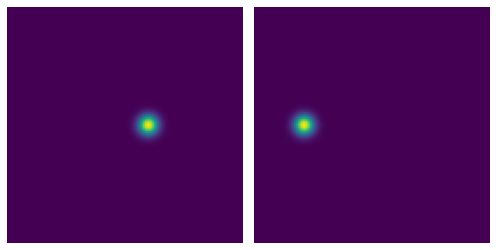

In [8]:
### For presentation figure

### Generate Gaussian blob image with and without deformation
### - use odd size image for centering

# amp = 1000  # a.u.
# ny = 65
# nx = 65

# g = gaussian_2d(ny, A=amp, sig_x=3, sig_y=3)  # using large amplitude because of scaling

# x1 = np.zeros((ny, nx))
# x2 = np.zeros((ny, nx))

# x1[32, 35] = 1
# x2[32, 10] = 1



amp = 1000  # a.u.
ny = 101
nx = 101

g = gaussian_2d(ny, A=amp, sig_x=3, sig_y=3)  # using large amplitude because of scaling

x1 = np.zeros((ny, nx))
x2 = np.zeros((ny, nx))

x1[50, 60] = 1
# x1[50, 50] = 1

x2[50, 21] = 1
# x2[50, 50] = 1

x1 = transforms.ift2(transforms.ft2(x1) * g).real
x2 = transforms.ift2(transforms.ft2(x2) * g).real

x1 = np.where(x1 < 0, 0, x1)
x2 = np.where(x2 < 0, 0, x2)

# x1 = np.where(x1>0.1, 1, 0)
# x2 = np.where(x2>0.1, 1, 0)


# x1 = np.zeros((ny, nx))
# x2 = np.zeros((ny, nx))
# x1[40:60, 40:60] = 1
# x2[40:60, 10:30] = 1

plots.two_imshow(x1, x2)

In [9]:
a = utils.rotate(x2, 135)
a = np.where(a < 0, 0, a)

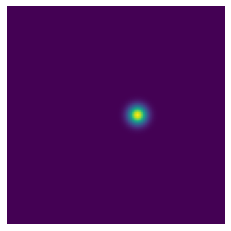

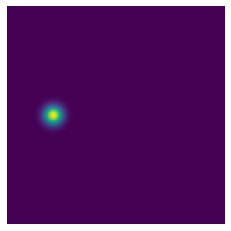

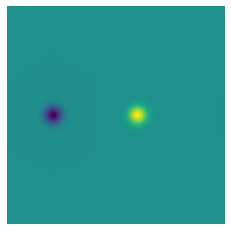

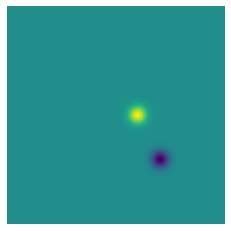

In [10]:
plt.imshow(x1)
plt.axis('off')
plt.show()

plt.imshow(x2)
plt.axis('off')
plt.show()

plt.imshow(x1 - x2)
plt.axis('off')
plt.show()

plt.imshow(x1 - a)
plt.axis('off')
plt.show()

In [22]:
dists_sw2 = dists_sw_nrf / np.amax(dists_sw_nrf)
dists_l2 = dists_bf / np.amax(dists_bf)

In [49]:
angles, angles[51]

(array([  0.        ,   3.56435644,   7.12871287,  10.69306931,
         14.25742574,  17.82178218,  21.38613861,  24.95049505,
         28.51485149,  32.07920792,  35.64356436,  39.20792079,
         42.77227723,  46.33663366,  49.9009901 ,  53.46534653,
         57.02970297,  60.59405941,  64.15841584,  67.72277228,
         71.28712871,  74.85148515,  78.41584158,  81.98019802,
         85.54455446,  89.10891089,  92.67326733,  96.23762376,
         99.8019802 , 103.36633663, 106.93069307, 110.4950495 ,
        114.05940594, 117.62376238, 121.18811881, 124.75247525,
        128.31683168, 131.88118812, 135.44554455, 139.00990099,
        142.57425743, 146.13861386, 149.7029703 , 153.26732673,
        156.83168317, 160.3960396 , 163.96039604, 167.52475248,
        171.08910891, 174.65346535, 178.21782178, 181.78217822,
        185.34653465, 188.91089109, 192.47524752, 196.03960396,
        199.6039604 , 203.16831683, 206.73267327, 210.2970297 ,
        213.86138614, 217.42574257, 220.

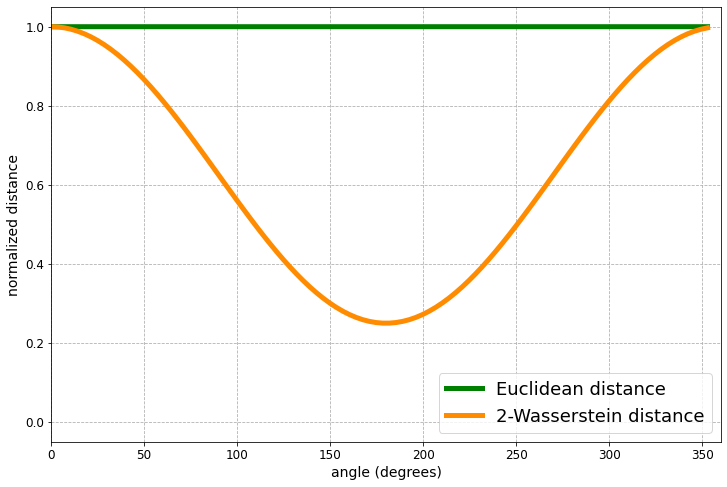

In [51]:
l = -1

plt.figure(figsize=(12,8))

plt.plot(angles[:l], dists_l2[:l], color='green', linewidth=5, label='Euclidean distance')
plt.plot(angles[:l], dists_sw2[:l], color='darkorange', linewidth=5, label='2-Wasserstein distance')

plt.legend(loc='lower right')
plt.grid(which='major', linestyle='--')
plt.ylim(-0.05, 1.05)
plt.ylabel('normalized distance')
plt.xlabel('angle (degrees)')
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=18)

plt.xlim((0, 360))
plt.savefig('/home/ev9102/ImageAlignment/FastAlignOT/Output/blob_example_360.pdf')
plt.show()